In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
# import packages for hyperparameters tuningpip inst
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score

e:\installations\python37\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
e:\installations\python37\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=T

In [2]:
def loadData():
    df=pd.read_csv('getARoom/dataset/train.csv')
    df.describe(include='all')
    return df

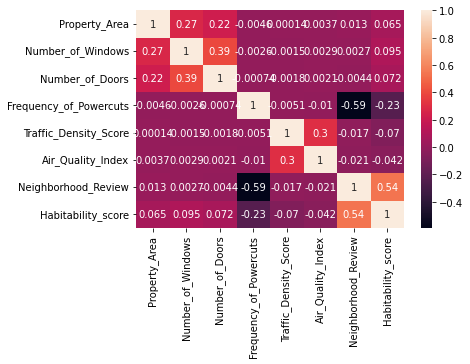

In [3]:
df=loadData()
matrix=df.corr()
sn.heatmap(matrix, annot=True)
plt.show()

In [4]:
df.describe(include='all')

,Property_ID,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
count,39499,39499,39499.000000,37845.000000,39499.000000,38457,38116.000000,39499,39499,39499.000000,38712,38280,39499.000000,39499.000000,39499.000000
unique,39499,6,NaN,NaN,NaN,3,NaN,3,5,NaN,4,3,NaN,NaN,NaN
top,0x21e3,Apartment,NaN,NaN,NaN,Semi_Furnished,NaN,No,All time,NaN,Well below average,Medium,NaN,NaN,NaN
freq,1,14596,NaN,NaN,NaN,20357,NaN,29714,19511,NaN,19472,32996,NaN,NaN,NaN
mean,NaN,NaN,1391.715638,3.923768,2.331375,NaN,0.484678,NaN,NaN,6.354772,NaN,NaN,121.352566,3.735945,73.482297
std,NaN,NaN,1953.287544,2.690992,1.179964,NaN,0.752207,NaN,NaN,1.219681,NaN,NaN,62.384669,0.796843,14.118753
min,NaN,NaN,100.000000,0.000000,1.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,7.280000
25%,NaN,NaN,494.000000,2.000000,1.000000,NaN,0.000000,NaN,NaN,5.600000,NaN,NaN,95.000000,3.220000,69.660000
50%,NaN,NaN,932.000000,4.000000,2.000000,NaN,0.000000,NaN,NaN,6.470000,NaN,NaN,113.000000,3.850000,75.760000
75%,NaN,NaN,1770.000000,5.000000,3.000000,NaN,1.000000,NaN,NaN,7.220000,NaN,NaN,140.000000,4.260000,82.260000


In [5]:
data_types=defaultdict(list)
for entry in df.columns:
    data_types[str(df[entry].dtypes)].append(entry)
    #     if str(df[entry].dtypes) =='object':
    #         print(df[entry].value_counts())
strings_used = [var for var in data_types["object"]]
#print(data_types)
#print(strings_used)

In [6]:
airquality_range = {range(0, 50): 'Good', range(50,100): 'Satisfactory', range(100, 300): 'Poor', range(300,400):'Very Poor',range(400,2000):'Very Poor'}
def preprocess(df,ledict):
    missing_data_fill = {'Furnishing':'Semi_Furnished','Crime_Rate':'Well below average','Dust_and_Noise':'Medium'}
    df = df.fillna(missing_data_fill)
    df_property_id=df['Property_ID']
    df = df.drop(['Property_ID'], axis=1, errors='ignore')
    df_habitability_score=df[['Habitability_score']]
    df = df[['Property_Type','Property_Area','Number_of_Windows','Number_of_Doors','Furnishing',
             'Frequency_of_Powercuts','Power_Backup','Water_Supply','Traffic_Density_Score',
             'Crime_Rate','Dust_and_Noise','Air_Quality_Index','Neighborhood_Review']]
    #Property_Area, Traffic_Density_Score
    
    df['Frequency_of_Powercuts']=df['Frequency_of_Powercuts'].fillna(2)
    df['Air_Quality_Index']=df['Air_Quality_Index'].apply(lambda x: next((v for k, v in airquality_range.items() if x in k), 0))
    for var in ['Property_Type','Power_Backup','Crime_Rate','Dust_and_Noise','Furnishing','Frequency_of_Powercuts','Water_Supply','Air_Quality_Index']:
        le=LabelEncoder()
        df[var]=le.fit_transform(df[var])
        ledict[var].append(le)
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoder_df = pd.DataFrame(encoder.fit_transform(df[[var]]).toarray())
        encoder_df=encoder_df.add_prefix(var+'_')
        ledict[var].append(encoder)
        #print(var,le.classes_,encoder_df)
        df=df.join(encoder_df)
        df= df.drop([var], axis=1, errors='ignore')
        #print(df.columns)
    df['Number_of_Windows']=df['Number_of_Windows'].fillna(df['Number_of_Doors']+1)
    #df['Furnishing']=df['Furnishing'].map({'Fully Furnished':2,'Semi_Furnished':1,'Unfurnished':0})
    #df['Frequency_of_Powercuts']=3-df['Frequency_of_Powercuts']
    #df['Water_Supply']=df['Water_Supply'].map({'All time':5,'NOT MENTIONED':4, 'Once in a day - Morning':3, 'Once in a day - Evening':2,'Once in two days':1})
    df['Traffic_Density_Score']=10-df['Traffic_Density_Score']
    return ledict,df,df_property_id,df_habitability_score#,scalars

def preprocess_test(df,ledict):
    missing_data_fill = {'Furnishing':'Semi_Furnished','Crime_Rate':'Well below average','Dust_and_Noise':'Medium'}
    df = df.fillna(missing_data_fill)
    df_property_id=df['Property_ID']
    df = df.drop(['Property_ID'], axis=1, errors='ignore')
    
    df['Frequency_of_Powercuts']=df['Frequency_of_Powercuts'].fillna(2)
    df['Air_Quality_Index']=df['Air_Quality_Index'].apply(lambda x: next((v for k, v in airquality_range.items() if x in k), 0))
    for var in ['Property_Type','Power_Backup','Crime_Rate','Dust_and_Noise','Furnishing','Frequency_of_Powercuts','Water_Supply','Air_Quality_Index']:
        #print(var,ledict[var][0].classes_)
        df[var]=ledict[var][0].transform(df[var])
        encoder_df = pd.DataFrame(ledict[var][1].transform(df[[var]]).toarray())
        encoder_df=encoder_df.add_prefix(var+'_')
        df=df.join(encoder_df)
        df= df.drop([var], axis=1, errors='ignore')
    df['Number_of_Windows']=df['Number_of_Windows'].fillna(df['Number_of_Doors']+1)
    #df['Furnishing']=df['Furnishing'].map({'Fully Furnished':2,'Semi_Furnished':1,'Unfurnished':0})
    #df['Frequency_of_Powercuts']=3-df['Frequency_of_Powercuts']
    #df['Water_Supply']=df['Water_Supply'].map({'All time':5,'NOT MENTIONED':4, 'Once in a day - Morning':3, 'Once in a day - Evening':2,'Once in two days':1})
    df['Traffic_Density_Score']=10-df['Traffic_Density_Score']
    return df,df_property_id

In [7]:
df=loadData()
ledict=defaultdict(list)
ledict,df,df_property_id,df_habitability_score=preprocess(df,ledict)
df.describe(include='all')

e:\installations\python37\lib\site-packages\sklearn\preprocessing\data.py:1961: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = check_array(X, dtype=np.int)
e:\installations\python37\lib\site-packages\sklearn\preprocessing\data.py:1961: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use,

,Property_Area,Number_of_Windows,Number_of_Doors,Traffic_Density_Score,Neighborhood_Review,Property_Type_0,Property_Type_1,Property_Type_2,Property_Type_3,Property_Type_4,...,Frequency_of_Powercuts_3,Water_Supply_0,Water_Supply_1,Water_Supply_2,Water_Supply_3,Water_Supply_4,Air_Quality_Index_0,Air_Quality_Index_1,Air_Quality_Index_2,Air_Quality_Index_3
count,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,...,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000
mean,1391.715638,3.895921,2.331375,3.645228,3.735945,0.012912,0.369528,0.107294,0.072711,0.146991,...,0.030229,0.493962,0.008734,0.197853,0.250563,0.048887,0.020102,0.676701,0.295045,0.008152
std,1953.287544,2.647775,1.179964,1.219681,0.796843,0.112895,0.482683,0.309490,0.259664,0.354101,...,0.171218,0.499970,0.093050,0.398386,0.433343,0.215635,0.140350,0.467742,0.456069,0.089921
min,100.000000,0.000000,1.000000,0.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,494.000000,2.000000,1.000000,2.780000,3.220000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,932.000000,3.000000,2.000000,3.530000,3.850000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1770.000000,5.000000,3.000000,4.400000,4.260000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,28064.000000,15.000000,6.000000,10.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
for key in ledict:
    print(key,ledict[key][0].classes_)

Property_Type ['#R%$G&867' 'Apartment' 'Bungalow' 'Container Home' 'Duplex'
 'Single-family home']
Power_Backup ['NOT MENTIONED' 'No' 'Yes']
Crime_Rate ['Slightly above average' 'Slightly below average' 'Well above average'
 'Well below average']
Dust_and_Noise ['High' 'Low' 'Medium']
Furnishing ['Fully Furnished' 'Semi_Furnished' 'Unfurnished']
Frequency_of_Powercuts [0. 1. 2. 3.]
Water_Supply ['All time' 'NOT MENTIONED' 'Once in a day - Evening'
 'Once in a day - Morning' 'Once in two days']
Air_Quality_Index ['Good' 'Poor' 'Satisfactory' 'Very Poor']


<AxesSubplot:>

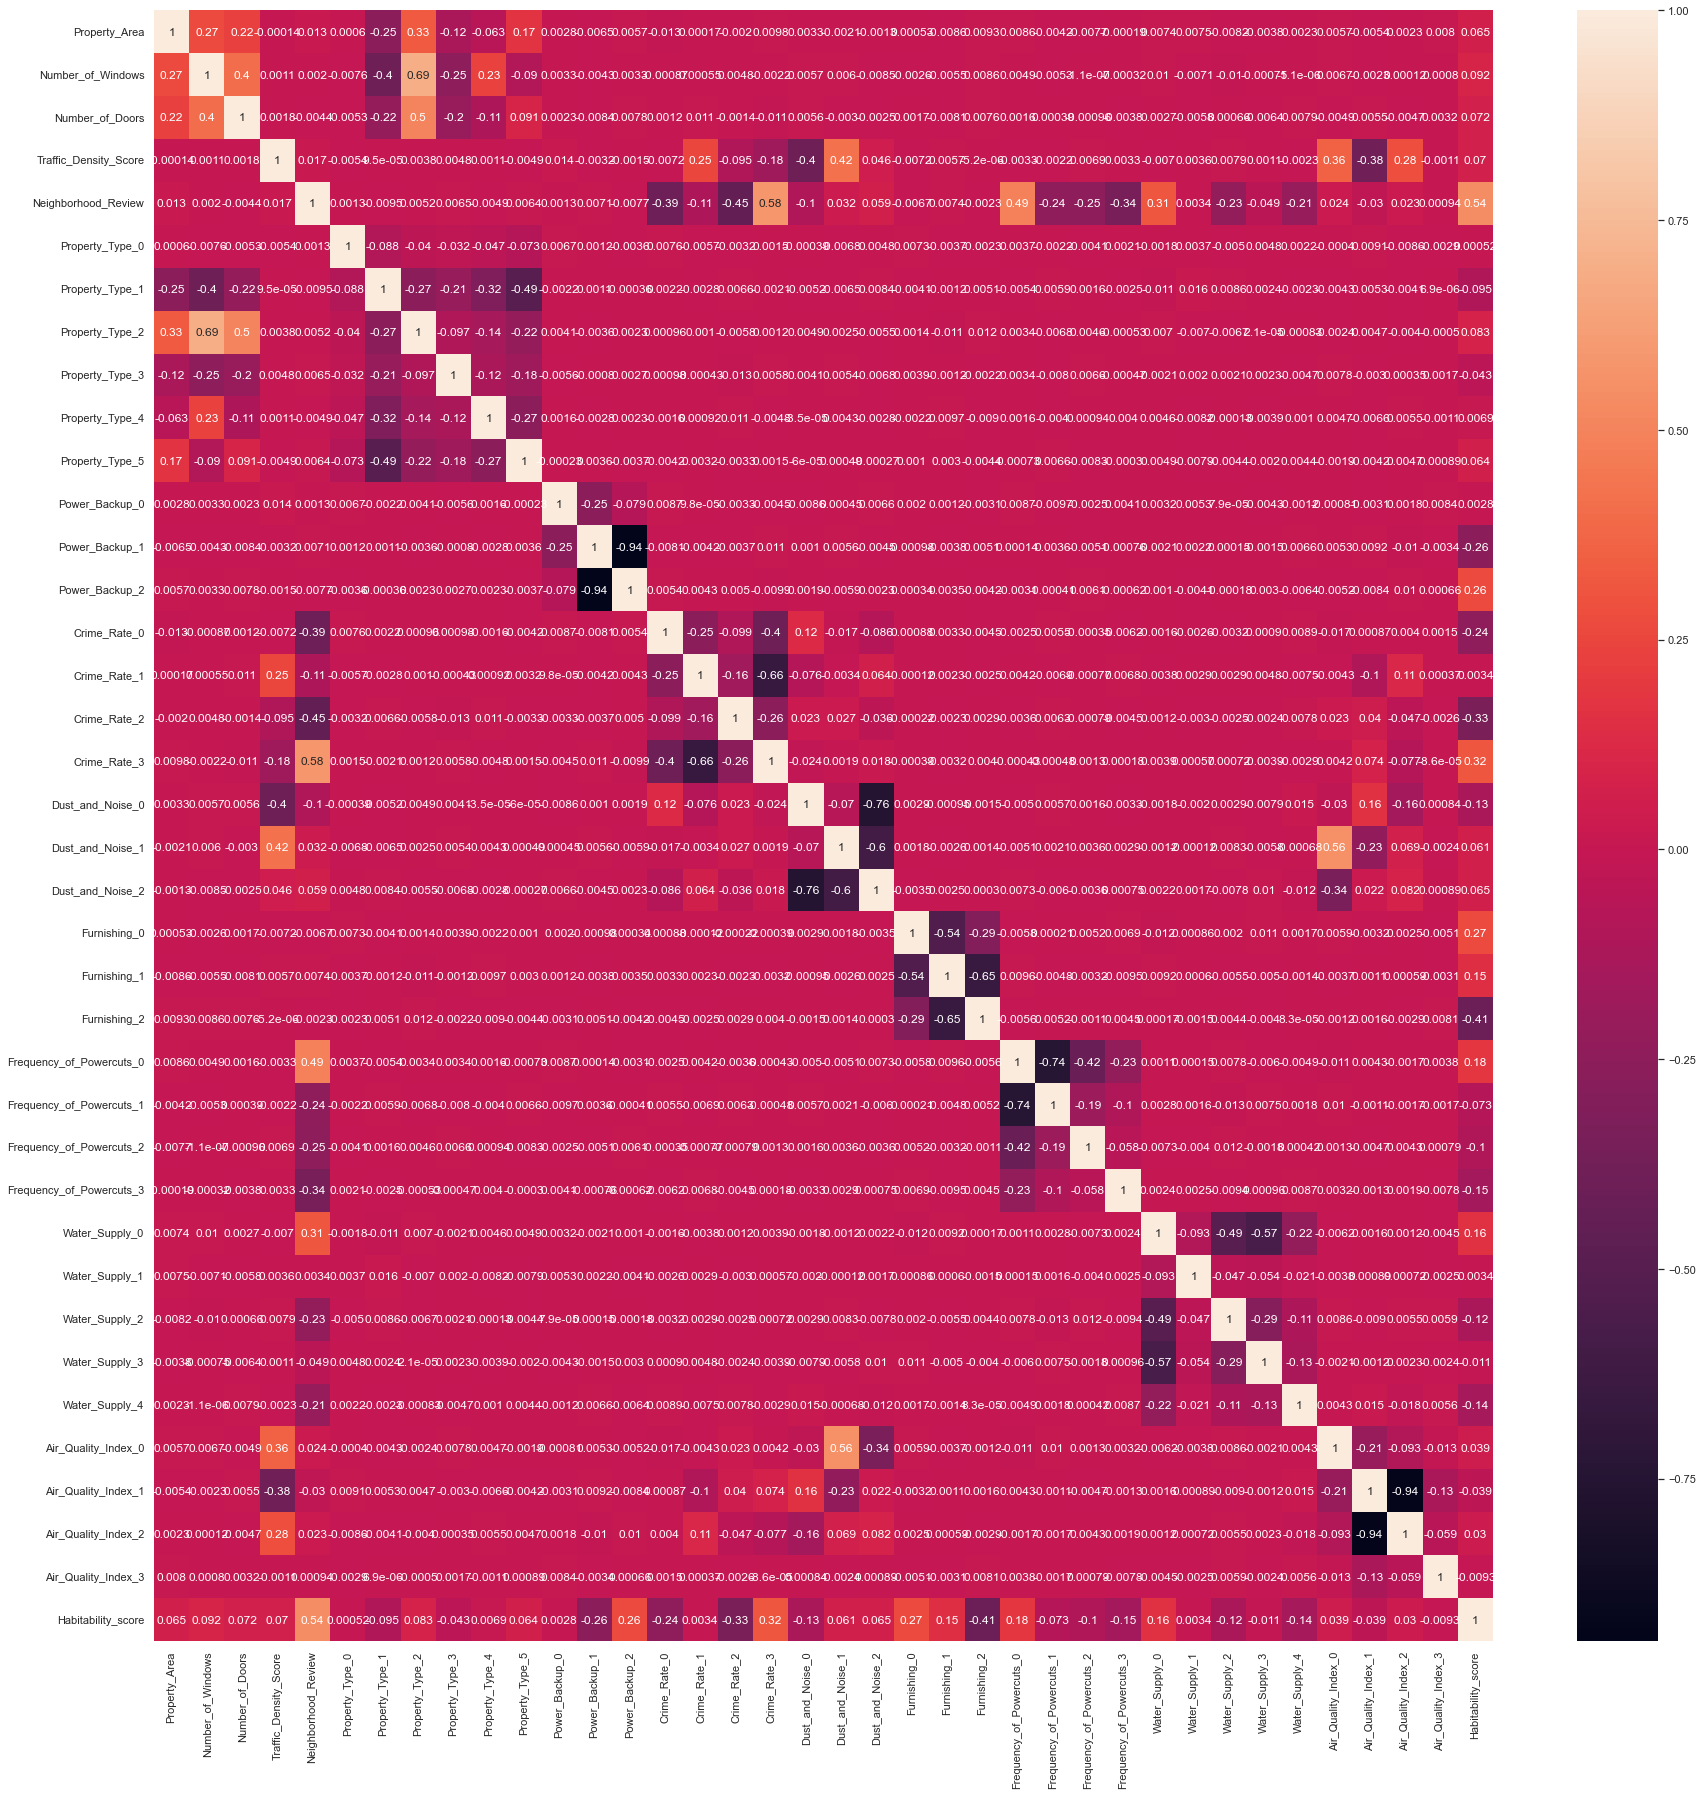

In [9]:
df2=df
df2=df2.join(df_habitability_score)
matrix=df2.corr()
sn.set(rc = {'figure.figsize':(30,30)})

sn.heatmap(matrix, annot=True)
#plt.show()

In [10]:
X=df
print(X)
y=df_habitability_score
print(y)

       Property_Area  Number_of_Windows  Number_of_Doors  \
0                106                2.0                1   
1                733                2.0                2   
2                737                4.0                2   
3                900                3.0                2   
4               2238               14.0                6   
...              ...                ...              ...   
39494           1120                3.0                2   
39495            445                1.0                3   
39496           3780                6.0                6   
39497           1266                3.0                1   
39498           1229                2.0                4   

       Traffic_Density_Score  Neighborhood_Review  Property_Type_0  \
0                       4.11                 3.86              0.0   
1                       5.63                 3.55              0.0   
2                       2.55                 3.81              0.0   

In [11]:
df.describe(include='all')

,Property_Area,Number_of_Windows,Number_of_Doors,Traffic_Density_Score,Neighborhood_Review,Property_Type_0,Property_Type_1,Property_Type_2,Property_Type_3,Property_Type_4,...,Frequency_of_Powercuts_3,Water_Supply_0,Water_Supply_1,Water_Supply_2,Water_Supply_3,Water_Supply_4,Air_Quality_Index_0,Air_Quality_Index_1,Air_Quality_Index_2,Air_Quality_Index_3
count,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,...,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000
mean,1391.715638,3.895921,2.331375,3.645228,3.735945,0.012912,0.369528,0.107294,0.072711,0.146991,...,0.030229,0.493962,0.008734,0.197853,0.250563,0.048887,0.020102,0.676701,0.295045,0.008152
std,1953.287544,2.647775,1.179964,1.219681,0.796843,0.112895,0.482683,0.309490,0.259664,0.354101,...,0.171218,0.499970,0.093050,0.398386,0.433343,0.215635,0.140350,0.467742,0.456069,0.089921
min,100.000000,0.000000,1.000000,0.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,494.000000,2.000000,1.000000,2.780000,3.220000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,932.000000,3.000000,2.000000,3.530000,3.850000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1770.000000,5.000000,3.000000,4.400000,4.260000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,28064.000000,15.000000,6.000000,10.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
pipeline = Pipeline([
    #("StandardScalar Scaling", StandardScaler()),
    ("Linear Regression", LinearRegression())
])

In [13]:
sc=StandardScaler()
X=sc.fit_transform(X)
X=pd.DataFrame(X)
X_train, X_test, y_train, y_test=train_test_split(X,y)

In [14]:
pipeline=pipeline.fit(X_train, y_train)
pipeline.score(X_test,y_test)

0.592193662145539

In [15]:
for value in ledict:
    print(ledict[value][0].classes_)

['#R%$G&867' 'Apartment' 'Bungalow' 'Container Home' 'Duplex'
 'Single-family home']
['NOT MENTIONED' 'No' 'Yes']
['Slightly above average' 'Slightly below average' 'Well above average'
 'Well below average']
['High' 'Low' 'Medium']
['Fully Furnished' 'Semi_Furnished' 'Unfurnished']
[0. 1. 2. 3.]
['All time' 'NOT MENTIONED' 'Once in a day - Evening'
 'Once in a day - Morning' 'Once in two days']
['Good' 'Poor' 'Satisfactory' 'Very Poor']


In [16]:
# pipeline = Pipeline([
#     #("StandardScalar Scaling", StandardScaler()),
#     ("XGBRegressor", XGBRegressor())
# ])
model=XGBRegressor()
model=model.fit(X_train,y_train)

In [17]:
model.score(X_test,y_test)

0.8013403157510365

<AxesSubplot:>

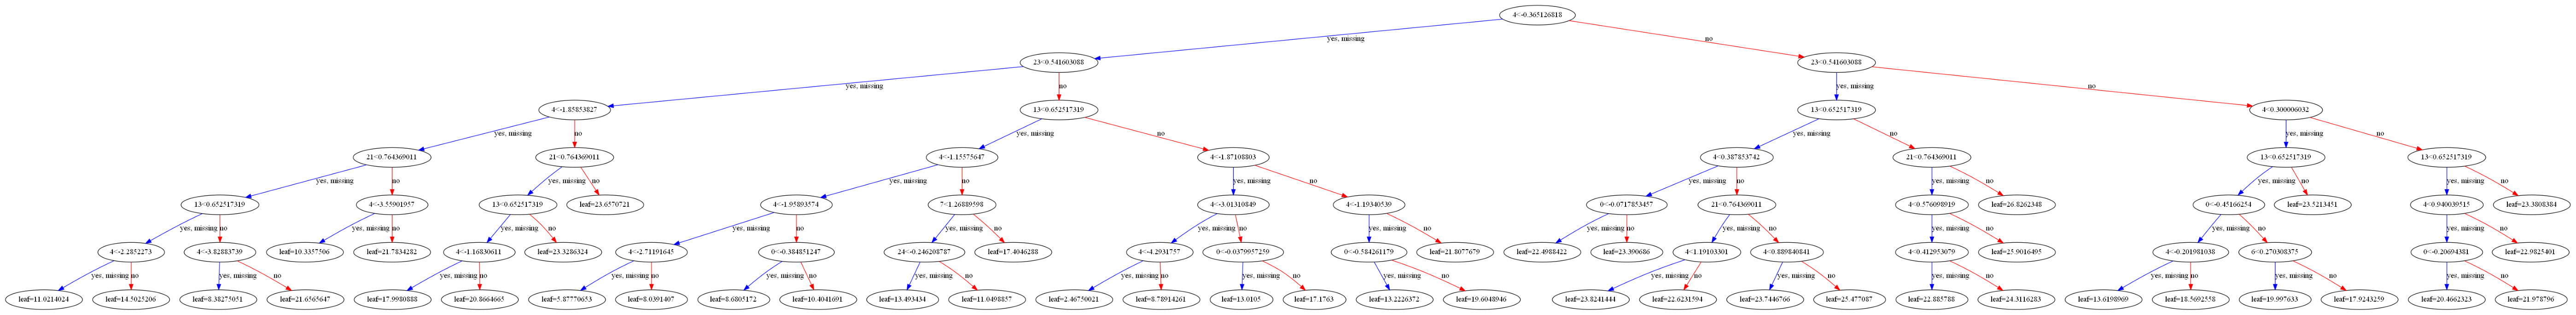

In [18]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 100,100

#plt.figure(figsize=(10, 10))
plot_tree(model)

#plt.show()
#plt.show()

In [19]:
'''clf=XGBRegressor( n_estimators=30000, max_depth=4,
                     learning_rate=.05, 
                     subsample=.8,
                     min_child_weight=3,
                     colsample_bytree=.8
                    )
    
evaluation = [( X_train, y_train), ( X_test, y_test)]

clf.fit(X_train, y_train,
        eval_set=evaluation, eval_metric="auc",
        early_stopping_rounds=10,verbose=False)


pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, pred>0.5)'''

'clf=XGBRegressor( n_estimators=30000, max_depth=4,\n                     learning_rate=.05, \n                     subsample=.8,\n                     min_child_weight=3,\n                     colsample_bytree=.8\n                    )\n    \nevaluation = [( X_train, y_train), ( X_test, y_test)]\n\nclf.fit(X_train, y_train,\n        eval_set=evaluation, eval_metric="auc",\n        early_stopping_rounds=10,verbose=False)\n\n\npred = clf.predict(X_test)\naccuracy = accuracy_score(y_test, pred>0.5)'

In [20]:
'''def objective(space):
    clf=XGBRegressor( n_estimators=30000, max_depth=4,
                     learning_rate=.05, 
                     subsample=.8,
                     min_child_weight=3,
                     colsample_bytree=.8
                    )
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }'''

'def objective(space):\n    clf=XGBRegressor( n_estimators=30000, max_depth=4,\n                     learning_rate=.05, \n                     subsample=.8,\n                     min_child_weight=3,\n                     colsample_bytree=.8\n                    )\n    \n    evaluation = [( X_train, y_train), ( X_test, y_test)]\n    \n    clf.fit(X_train, y_train,\n            eval_set=evaluation, eval_metric="auc",\n            early_stopping_rounds=10,verbose=False)\n    \n\n    pred = clf.predict(X_test)\n    accuracy = accuracy_score(y_test, pred>0.5)\n    print ("SCORE:", accuracy)\n    return {\'loss\': -accuracy, \'status\': STATUS_OK }'

In [21]:
'''space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials)'''

'space={\'max_depth\': hp.quniform("max_depth", 3, 18, 1),\n        \'gamma\': hp.uniform (\'gamma\', 1,9),\n        \'reg_alpha\' : hp.quniform(\'reg_alpha\', 40,180,1),\n        \'reg_lambda\' : hp.uniform(\'reg_lambda\', 0,1),\n        \'colsample_bytree\' : hp.uniform(\'colsample_bytree\', 0.5,1),\n        \'min_child_weight\' : hp.quniform(\'min_child_weight\', 0, 10, 1),\n        \'n_estimators\': 180,\n        \'seed\': 0\n    }\n\ntrials = Trials()\n\nbest_hyperparams = fmin(fn = objective,\n                        space = space,\n                        algo = tpe.suggest,\n                        max_evals = 20,\n                        trials = trials)'

In [22]:
testfileDF=pd.read_csv('getARoom/dataset/test.csv')
ledict

defaultdict(list,
            {'Property_Type': [LabelEncoder(),
              OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
                     handle_unknown='ignore', n_values='auto', sparse=True)],
             'Power_Backup': [LabelEncoder(),
              OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
                     handle_unknown='ignore', n_values='auto', sparse=True)],
             'Crime_Rate': [LabelEncoder(),
              OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
                     handle_unknown='ignore', n_values='auto', sparse=True)],
             'Dust_and_Noise': [LabelEncoder(),
              OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
                     handle_unknown='ignore', n_values='auto', sparse=True)],
             'Furnishing': [LabelEncoder(),
              OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
      

In [23]:
X_test_file,df_property_id=preprocess_test(testfileDF,ledict)

e:\installations\python37\lib\site-packages\sklearn\preprocessing\data.py:2023: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = check_array(X, dtype=np.int)
e:\installations\python37\lib\site-packages\sklearn\preprocessing\data.py:2023: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use,

In [24]:
res=pipeline.predict(X_test_file)
#res=model.predict(X_test_file)

In [25]:
df=pd.DataFrame()
df['Property_ID']=df_property_id
df2=pd.DataFrame(res)
df['Habitability_score']=df2
df

,Property_ID,Habitability_score
0,0x6e93,4.406566e+12
1,0x8787,2.217398e+13
2,0x6c17,3.781187e+12
3,0x9dbd,1.463289e+13
4,0xbfde,-8.759319e+12
...,...,...
10495,0x423d,2.197359e+13
10496,0x78c5,8.027339e+12
10497,0xbf3,1.441317e+13
10498,0x305b,2.590381e+13


In [26]:
df.to_csv('submission.csv',index=False)

In [27]:
pipeline

Pipeline(memory=None,
     steps=[('Linear Regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [28]:
from sklearn.tree import DecisionTreeRegressor
for i in range(5,20):
    regr = DecisionTreeRegressor(max_depth=i)
    regr=regr.fit(X_train,y_train)
    print(regr.score(X_test,y_test))

0.6964278233775225
0.7296317028710689
0.7494449412059667
0.7630077389466882
0.7743845241503495
0.77828406222264
0.7726656501183814
0.7680949489749184
0.7594855180808164
0.7432807601072802
0.7338145600278804
0.7204886590609314
0.715296096214231
0.6985744590465821
0.684993090837722


In [29]:
# plt.figure()
# plt.scatter(X_train, y_train, s=20, edgecolor="black", c="darkorange", label="data")
# plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
# plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
# plt.xlabel("data")
# plt.ylabel("target")
# plt.title("Decision Tree Regression")
# plt.legend()
# plt.show()

In [30]:
plt.show()